In [2]:
import sys
sys.path.append('../lib/')
from BlackbodyFunctions import *

0.11400392702867283595
0.1140039270276700888
0.11400392700764653655


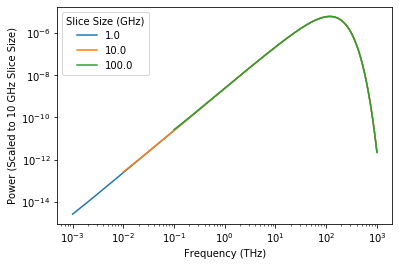

In [3]:
def makePlot(slice_size,useTrap=False):
    freqs = np.arange(slice_size,1e15,slice_size)
    w = blackbodyWeights(freqs,slice_size,useTrap=useTrap)
    plot(freqs*1e-12,w*(1e10/slice_size),label=slice_size*1e-9)
    print(np.sum(w))
    yscale('log')
    xscale('log')
    
for slice_size in [1e9,1e10,1e11]:
    makePlot(slice_size,useTrap=True)
legend(title='Slice Size (GHz)',loc='upper left')
xlabel('Frequency (THz)')
ylabel('Power (Scaled to 10 GHz Slice Size)')
show()